# Exercise: Tackling the Explore-Exploit Dilemma using Epsilon Greedy

Here, we will learn about the *explore-exploit dilemma*. We start off with an example using a **greedy approach** with multi-armed bandits whence we will observe the above dilemma. To go around this, we use the **epsilon greedy** algorithm and investigate its performance compared to the greedy approach.

Not required for the homework: a little more than a year ago, you may have seen headlines along the lines of "*AI has solved Atari games*". The related paper: https://adrien.ecoffet.com/files/go-explore-nature.pdf introduces a new algorithm called **Go-explore**, which exceeds human performance on all previously unsolved Atari games. If you are interested, you could read the first few pages of the paper, where they explain the algorithm and the motivation for it.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Reproducible random number generation in NumPy
 
First, a brief refresher on sampling random variables in `NumPy`. Of course, you have all done this before, but here is a tutorial in the best practice for reproducible random number generation using `NumPy`'s latest tools. Here, "reproducible" means that the simulation will generate the same results across different runs, which is an important tool to have in your data science toolbox when you want to share results that others can replicate!

In [3]:
# here, we instantiate a random generator, which can be used
# to sample random variables
# this is a Generator object, see: https://numpy.org/doc/stable/reference/random/generator.html
# Notice that we set the seed here. This means that
# repeated runs of this notebook will have the same
# behavior.
rg = np.random.default_rng(0)

# to draw samples from a normal random variable with mean mu
# and standard deviation sigma, we can do it like so:
mu = 10
sigma = 2
sample = rg.normal(loc=mu, scale=sigma)
print("One sample:", sample)

# to draw multiple samples, we can use
samples = rg.normal(loc=mu, scale=sigma, size=5)
print("Five samples:", samples)

# if we want to sample from multiple means at once
# using a shared standard deviation, we can use:
mu_vec = [0, 5, 10]
sigma = 1
mu_samples = rg.normal(loc=mu_vec, scale=sigma)
print("Samples with 3 means:", mu_samples)
# notice that `mu_samples.shape == (3,)`!

One sample: 10.251460442186787
Five samples: [ 9.73579027 11.2808453  10.20980023  8.92866125 10.72319011]
Samples with 3 means: [1.30400005 5.94708096 9.29626476]


The most important thing to notice above is that the `scale` parameter is the standard deviation, not the variance!

Below, please use `rg` to draw your random numbers. The documentation for the normal function is here: https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html

## 2-armed Bandit with Binary Rewards using the Greedy Approach

Let us implement 2-armed bandit with binary rewards, where it will be very clear that we run into the explore-exploit dilemma.

Suppose we pull the arms on two different bandits, which have equal payoffs. However, we only have enough resources for a total of 12 pulls.

Suppose further that bandit 1 has payoff probability $40\%$ while bandit 2 has payoff probability $90\%$. Since we have no prior information on either bandits, we decide to pull the arm three times on each bandit to collect information about them. This is what we observe:

**Bandit 1:** `Success, Success, Failure` 

**Bandit 2:** `Failure, Success, Failure`

According to the true payoff probabilities, the $p$-value of observing Bandit 1's result is 
$$\mathbb{P}(\textrm{Bin}(3, 0.4) \geq 2) = \binom{3}{1}0.4^2\times(0.6) + 0.4^3=0.352$$
and $p$-value of observing Bandit 2's result is 
$$\mathbb{P}(\textrm{Bin}(3, 0.9) \leq 1) = \binom{3}{1}(0.9)\times 0.1^2+0.1^3=0.028.$$
Note that neither events are extremely unlikely to observe in a real-life scenario.

Based on these observations, our average reward on bandit 1 is $\hat{\mu}_1(0)=2/3$ while our average reward on bandit 2 is $\hat{\mu}_2(0)=1/3$. The `Greedy` algorithm is as follows (in our case, $K=2$).


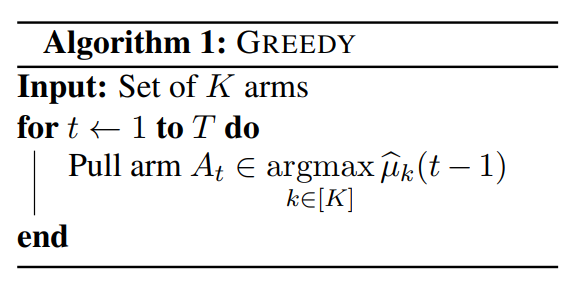

For the remaining 6 arm pulls, we follow the Greedy algorithm. Suppose `X1` and `X2` would be the realizations from pulling Bandits 1 and 2 for the next 6 pulls (though we do not get to pull both bandits 6 times since we only have 6 remaining pulls). The $1$'s represent successes while the $0$'s represent failures in the payoffs.

In [4]:
# set seed again (just in case you run this block multiple times)
rg = np.random.default_rng(0)

# Realizations of Arms 1 and 2
X1 = rg.binomial(1, 0.4, 6)
X2 = rg.binomial(1, 0.9, 6)
print('Bandit 1: ' + str(X1))
print('Bandit 2: ' + str(X2))

Bandit 1: [1 0 0 0 1 1]
Bandit 2: [1 1 1 0 1 1]


### Question 1:

1.  For the next 6 pulls, list, from time $t=1$ to $t=6$, from which bandit we should pull according to the Greedy algorithm.
2.  In the context of the example, explain how the Greedy algorithm tends to exploit. What could have happened to our total payoff if we decided to explore?

This example captures the explore-exploit dilemma.

**Question 1 Solution:**
1. We should pull Bandit 1 according to the Greedy algorithm.
2. The greedy algorithm tends to exploit the optimal solution to maximize performance based on current knowledge. In this context of example, it exploits which bandit we should pull to maximize the reward over times based on the first 6 pulls (3 on each bandit) with no prior information. Thus, the Greedy algorithm will tends to choose Bandit 1 as the optimal solution according to the first 6 pulls. The result would get worse and worse. If we decided to explore, we would increase knowledge about the value and uncertainty of pulling 2 different bandits. In this context, we might choose to pull Bandit 2 since we will have further information based on future pulls, and Bandit 2 has higher probability to get success compared to Bandit 1. Thus, it might change the result and we may have more total payoff if we choosed Bandit 2 based on the explore results.


## 5-armed Bandit with Gaussian Rewards using the Epsilon-Greedy Approach

Take the Greedy algorithm, but instead at each step we do the following for $0<\epsilon<1$:
\begin{align}
\textrm{Pull Arm } &A_t \in \arg\max_{k\in [K]} \hat{\mu}_k(t-1) \textrm{ with probability } 1-\epsilon\\
\textrm{Pull Arm } &A_t \sim \textrm{DiscreteUniform}\{1,2,\cdots,K\}\textrm{ with probability } \epsilon.
\end{align}

That is, with probability $1-\epsilon$, we choose the arm with highest average reward thus far, and with probability $\epsilon$, we choose an arm uniformly at random. This is the **epsilon-greedy approach**. In the case that the $\arg \max$ is not unique, let us just choose the smallest number in the $\arg \max$ set.

Let us implement both the epsilon-greedy approach and the greedy approach and see which one performs better.

### Set-up

First, we get an estimate by generating some number of samples from the $\textrm{Normal}(\mu_k,1)$ distribution for $k\in [K]=\{1,2,\cdots,k\}$, where the variable `mu` $= (\mu_1,\mu_2,\cdots,\mu_k)$.



In [5]:
num_samples = 5
num_bandits = 5
# set seed again (just in case you run this block multiple times)
rg = np.random.default_rng(0)
mu = rg.normal(0,1,num_bandits)

X = np.array([rg.normal(mu_k, 1, num_samples) for mu_k in mu])
average_rewards = np.mean(X, axis = 1)
print('mu: ' + str(mu))
print('average rewards: ' + str(average_rewards))


mu: [ 0.12573022 -0.13210486  0.64042265  0.10490012 -0.53566937]
average rewards: [ 0.25443409 -1.00644124  0.61268613  0.47044299 -0.89741798]


### Question 2

For the next 1000 iterations ($t=1$ to $T=1000$), implement both 
1.   the greedy algorithm
2.   and the epsilon-greedy algorithm

based on the average rewards we observed in the previous part, still keeping track of the average rewards.

Report the total rewards of each algorithm.

In [12]:
# set seed again (just in case you run this block multiple times)
rg = np.random.default_rng(0)
np.random.seed(0)

# Parameters
T = 1000
eps = 0.01

# fill up with nans so that we can use np.nanmean to avoid keeping track of empty rewards
rewards_greedy = np.full((num_bandits, T+num_samples), np.nan)
rewards_eps_greedy = np.full((num_bandits, T+num_samples), np.nan)
rewards_greedy[:, :num_samples] = X
rewards_eps_greedy[:, :num_samples] = X

estimates_greedy = np.nanmean(rewards_greedy, axis=1)
estimates_eps_greedy = np.nanmean(rewards_eps_greedy, axis=1)
# Keep track of whether rewards were given at time t
total_rewards_eps_greedy = np.zeros(T)
total_rewards_greedy = np.zeros(T)


for t in range(T):
  # Greedy algorithm

  ### YOUR CODE HERE ###
  arm_t = np.argmax(estimates_greedy)
  reward_t = rg.normal(mu[arm_t], 1)
  rewards_greedy[arm_t, t+num_samples] = reward_t
  estimates_greedy = np.nanmean(rewards_greedy, axis=1)
  total_rewards_greedy[t] = reward_t

  # Epsilon-greedy algorithm
  eps_result = rg.binomial(1, eps, 1)
  if eps_result == 1:
    ### YOUR CODE HERE ###
    arm_t = rg.integers(num_bandits,size=1)
    reward_t = rg.normal(mu[arm_t], 1)
    rewards_eps_greedy[arm_t, t+num_samples] = reward_t
  else:
    ### YOUR CODE HERE ###
    arm_t = np.argmax(estimates_eps_greedy)
    reward_t = rg.normal(mu[arm_t], 1)
    rewards_eps_greedy[arm_t, t+num_samples] = reward_t
  estimates_eps_greedy = np.nanmean(rewards_eps_greedy, axis=1)
  total_rewards_eps_greedy[t] = reward_t

print('Total rewards of Greedy approach: ' + str(np.nansum(rewards_greedy)))
print('Total rewards of Epsilon-Greedy approach: ' + str(np.nansum(rewards_eps_greedy)))


Total rewards of Greedy approach: 573.6193717885928
Total rewards of Epsilon-Greedy approach: 644.654559064862


### Question 3

Let $r_t$ be the reward at time $t$. 


1.   Plot the average reward $\frac{1}{T}\sum_{t\leq T} r_t$ as a function of time $t$ for both the greedy and epsilon-greedy algorithms.
2.   For every $t\geq 1$, calculate $\mathbb{E}[r_t]$. For any $\epsilon\in(0,1)$ fixed, can $\frac{1}{T}\sum_{t\leq T} r_t \rightarrow \max_k \mu_k$ as $T\rightarrow\infty$ under the epsilon-greedy algorithm? To do so, argue that $\mathbb{E}[r_t]< \max_k \mu_k$ if the $\mu_k$ are not identically the same. Your answer does not have to be mathematically rigorous.

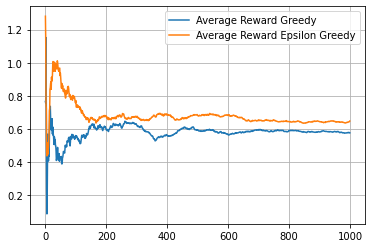

In [13]:
### YOUR CODE HERE ###
import pandas as pd
average_rewards_greedy = pd.Series(total_rewards_greedy).expanding().mean()
average_rewards_eps_greedy = pd.Series(total_rewards_eps_greedy).expanding().mean()
plt.plot(average_rewards_greedy, label='Average Reward Greedy')
plt.plot(average_rewards_eps_greedy, label='Average Reward Epsilon Greedy')
plt.legend()
plt.grid()

In [27]:
# Solution

**Question 3.2. Solution**

No. Under the epsilon-greedy algorithm, we start with a random arm and switch to another arm with probability ϵ. Each arm has same probability $1/(K-1)$ to be chosen. Thus, as $T\rightarrow\infty$, the average reward $\frac{1}{T}\sum_{t\leq T} r_t=\frac{ϵ}{K-1}∑\mu_k+(1-ϵ)μ_p < max_k~μ_k$. 


### Question 4

Here, we investigate the effects of changing some of the parameters.

1.   Print `rewards_greedy[:, 990]` and `rewards_eps_greedy[:, 990]`. What do you observe? How do you interpret the results?
2.   Redo Question 2 instead with $\epsilon = 0.999$ with $T$ fixed. Report your findings on the changes. Are these changes surprising? Provide an explanation.


**Question 4 Solution:**



In [14]:
print(rewards_greedy[:, 990])
print(rewards_eps_greedy[:, 990])

[       nan        nan 0.70007135        nan        nan]
[      nan       nan 0.3631443       nan       nan]


Question 4.1: 

From the results above, we can observe that the two rewards are different since at time t=989 epsilon-greedy algorithm would explore another action and get a reward of discrete uniform variable from 1 to 5 arms. Thus, at time t=990, epsilon-greedy algorithm may get reward result on any of the 5 arms with equal chance. But the greedy algorithm is still exploiting on the same arm at time t=990.

In [9]:
# set seed again (just in case you run this block multiple times)
rg = np.random.default_rng(0)
np.random.seed(0)

# Parameters
T = 1000
eps = 0.999

# fill up with nans so that we can use np.nanmean to avoid keeping track of empty rewards
rewards_greedy = np.full((num_bandits, T+num_samples), np.nan)
rewards_eps_greedy = np.full((num_bandits, T+num_samples), np.nan)
rewards_greedy[:, :num_samples] = X
rewards_eps_greedy[:, :num_samples] = X

estimates_greedy = np.nanmean(rewards_greedy, axis=1)
estimates_eps_greedy = np.nanmean(rewards_eps_greedy, axis=1)
# Keep track of whether rewards were given at time t
total_rewards_eps_greedy = np.zeros(T)
total_rewards_greedy = np.zeros(T)


for t in range(T):
  # Greedy algorithm

  ### YOUR CODE HERE ###
  arm_t = np.argmax(estimates_greedy)
  reward_t = rg.normal(mu[arm_t], 1)
  rewards_greedy[arm_t, t+num_samples] = reward_t
  estimates_greedy = np.nanmean(rewards_greedy, axis=1)
  total_rewards_greedy[t] = reward_t

  # Epsilon-greedy algorithm
  eps_result = rg.binomial(1, eps, 1)
  if eps_result == 1:
    ### YOUR CODE HERE ###
    arm_t = rg.integers(num_bandits,size=1)
    reward_t = rg.normal(mu[arm_t], 1)
    rewards_eps_greedy[arm_t, t+num_samples] = reward_t
  else:
    ### YOUR CODE HERE ###
    arm_t = np.argmax(estimates_eps_greedy)
    reward_t = rg.normal(mu[arm_t], 1)
    rewards_eps_greedy[arm_t, t+num_samples] = reward_t
  estimates_eps_greedy = np.nanmean(rewards_eps_greedy, axis=1)
  total_rewards_eps_greedy[t] = reward_t

print('Total rewards of Greedy approach: ' + str(np.nansum(rewards_greedy)))
print('Total rewards of Epsilon-Greedy approach: ' + str(np.nansum(rewards_eps_greedy)))

Total rewards of Greedy approach: 618.853937356092
Total rewards of Epsilon-Greedy approach: 33.74650344362446


Question 4.2: 

When epsilon is equal to 0.01, the two reward plots converge and total rewards are close. When epsilon is changed to 0.999, the two plots has a large difference with very different total rewards. The changes are quite obvious. It is because the rewards from normal distribution and uniform distribution are so different with the impact of large value of epsilon.